Few-shot image generation (Daniil Lotkov & Pierre Ebert)
======

In [ ]:
!pip install pytorch-fid

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2

import matplotlib.pyplot as plt
plt.set_cmap('gray')
%matplotlib inline

In [ ]:
use_google_drive = False

if use_google_drive:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/My\ Drive/AugIntAE/
    !pwd

Parameter Settings
-------------------


In [ ]:
latent_dims = 32
num_epochs = 50
batch_size = 128
capacity = 64
learning_rate = 1e-3
use_gpu = True
generator_period = 5

if_use_discriminator = True

#torch.cuda.manual_seed(seed=1)
#torch.random.manual_seed(1)      

MNIST Data Loading
-------------------

In [ ]:
%%capture

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, EMNIST, FashionMNIST

img_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,)) # I don't include it here cuz affine needs [0, 1]
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


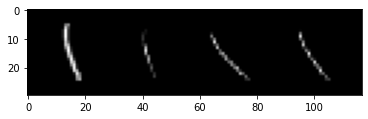

In [ ]:
#Image manipulation tools
import PIL
import numpy as np
import torchvision
from copy import deepcopy


def sample_in_range(range_):
    sample = None
    if type(range_[0]) is tuple:
        sample = (sample_in_range(range_[0]), sample_in_range(range_[1]))
    else:
        sample = type(range_[0])(np.random.uniform(range_[0], range_[1]))
    return sample

def sample_augmentations(augmentation_ranges):
    augmentations = deepcopy(augmentation_ranges)
    for function, arguments in augmentations.items():
        arguments['parameters'] = {}
        for name, range_ in arguments.get('ranges', {}).items():
            arguments['parameters'][name] = sample_in_range(range_)
    return augmentations

def weight_values(value_1, value_2, alpha):
    value = None
    if type(value_1) is not tuple:
        value = alpha * value_1 + (1 - alpha) * value_2
    else:
        value = (alpha * value_1[0] + (1 - alpha) * value_2[0],
                 alpha * value_1[1] + (1 - alpha) * value_2[1])
    return value

def get_weighted_augmentations(augmentations_1, augmentations_2, alpha=0.5):
    mean_augmentations = deepcopy(augmentations_1)
    for function in augmentations_1:
        for name in mean_augmentations[function]['parameters']:
            mean_augmentations[function]['parameters'][name] = \
                        weight_values(augmentations_1[function]['parameters'][name], 
                                     augmentations_2[function]['parameters'][name],
                                     alpha=alpha)
    return mean_augmentations
      
def apply_augmentations(image_batch, augmentations):
    augmented_image_batch = image_batch
    for function, arguments in augmentations.items():
        augmented_image_batch = function(augmented_image_batch, **arguments['parameters'], **arguments.get('kwargs', {}))
    return augmented_image_batch


augmentation_ranges = {
    torchvision.transforms.functional.affine: {
        'ranges': {
            'angle': (-20, 20),
            'translate': ((-4, 4), (-4, 4)),
            'scale': (0.8, 1.2),
        },
        'kwargs': {
            'shear': (-6,6),
            'resample': PIL.Image.BILINEAR,

            # For testing without interpolation 
            # (uncomment this and comment out 'ranges')
            #
            # 'angle': 0,
            # 'translate': (0, 0),
            # 'scale': 1,
        },
    },

    torchvision.transforms.functional.normalize: {
        'kwargs': {
            'mean': 0.5,
            'std': 0.5,
        },
    },
}

alpha = 0.3

for image_batch, _ in train_dataloader:
    augmentations_1 = sample_augmentations(augmentation_ranges)
    augmentations_2 = sample_augmentations(augmentation_ranges)
    augmentations_combined = get_weighted_augmentations(augmentations_1,
                                                        augmentations_2,
                                                        alpha=alpha)
    
    image_batch_1 = apply_augmentations(image_batch, augmentations_1)
    image_batch_2 = apply_augmentations(image_batch, augmentations_2)
    image_batch_combined = apply_augmentations(image_batch, augmentations_combined)

    np_imagegrid = torchvision.utils.make_grid(
                  [image_batch[0], image_batch_1[0], image_batch_2[0], image_batch_combined[0]], 
                  4, 1).numpy()
    plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
    plt.show()

    break

Adversarial AugIntAE Definition
-----------------------

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.bn1 = nn.BatchNorm2d(c*2)
        self.fc1 = nn.Linear(in_features=c*2*7*7, out_features=c*7*7)
        self.bn2 = nn.BatchNorm1d(c*7*7)
        self.fc2 = nn.Linear(in_features=c*7*7, out_features=latent_dims)
           
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.1)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.1)
        x = self.bn1(x)
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.bn2(F.leaky_relu(self.fc1(x), negative_slope=0.1))
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()
        c = capacity
        self.fc2 = nn.Linear(in_features=latent_dims, out_features=c*7*7)
        self.bn3 = nn.BatchNorm1d(c*7*7)
        self.fc1 = nn.Linear(in_features=c*7*7, out_features=2*c*7*7)
        self.bn2 = nn.BatchNorm1d(2*c*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(c)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = F.relu(self.fc2(x))
        x = self.bn3(x)
        x = F.relu(self.fc1(x))
        x = self.bn2(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = self.bn1(x)
        x = torch.tanh(self.conv1(x)) # last layer before output is tanh, since the images are normalized and 0-centered
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.bn1 = nn.BatchNorm2d(c*2)
        self.fc1 = nn.Linear(in_features=c*2*7*7, out_features=c*7*7)
        self.bn2 = nn.BatchNorm1d(c*7*7)
        self.fc2 = nn.Linear(in_features=c*7*7, out_features=1)
            
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = self.bn1(x)
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = F.leaky_relu(self.fc1(x))
        x = self.bn2(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x

encoder = Encoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
encoder = encoder.to(device)

num_params = sum(p.numel() for p in encoder.parameters() if p.requires_grad)
print('Number of parameters encoder: %d' % num_params)


decoder = Decoder()
#for name, param in decoder.named_parameters():
#    if param.requires_grad:
#        print (name, param.shape)
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
decoder = decoder.to(device)

num_params = sum(p.numel() for p in decoder.parameters() if p.requires_grad)
print('Number of parameters decoder: %d' % num_params)

if if_use_discriminator:
    discriminator = Discriminator()

    device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
    discriminator = discriminator.to(device)

    num_params = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
    print('Number of parameters discriminator: %d' % num_params)

Number of parameters encoder: 19911328
Number of parameters decoder: 19929857
Number of parameters discriminator: 19814081


Train Adversarial AugIntAE
--------

In [ ]:
from tqdm.notebook import tqdm

optimizer_encoder = torch.optim.Adam(params=encoder.parameters(), lr=learning_rate, weight_decay=1e-5)
optimizer_decoder = torch.optim.Adam(params=decoder.parameters(), lr=learning_rate, weight_decay=1e-5)
if if_use_discriminator:
  optimizer_discriminator = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
encoder.train()
decoder.train()

if if_use_discriminator:
    discriminator.train()

loss_rec_avg = []
loss_adv_avg = []
loss_adv_true = []
loss_adv_false = []

i=0
k=1

#Optional gradient norm regulation parameters
autoencoder_norm = 1
discrim_norm = 1

print('Training ...')
for epoch in range(num_epochs):
    loss_rec_avg.append(0)
    loss_adv_avg.append(0)
    loss_adv_true.append(0)
    loss_adv_false.append(0)
    num_batches = 0
    
    for image_batch, _ in tqdm(train_dataloader):
        
        #Sampling interpolation coefficient for the batch
        alpha=torch.distributions.uniform.Uniform(0.,1.).sample().numpy()

        #Sampling and applying augmentations for the batch
        augmentations_1 = sample_augmentations(augmentation_ranges)
        augmentations_2 = sample_augmentations(augmentation_ranges)
        augmentations_combined = get_weighted_augmentations(augmentations_1,
                                                            augmentations_2,
                                                            alpha=alpha)
        
        image_batch_1 = apply_augmentations(image_batch, augmentations_1)
        image_batch_2 = apply_augmentations(image_batch, augmentations_2)
        image_batch_combined = apply_augmentations(image_batch, augmentations_combined)
        
        image_batch_1 = image_batch_1.to(device)
        image_batch_2 = image_batch_2.to(device)
        image_batch_combined = image_batch_combined.to(device)

        # encoding
        image_batch_1_encoding = encoder(image_batch_1)
        image_batch_2_encoding = encoder(image_batch_2)
        alpha = torch.Tensor(alpha)
        
        # combining encodings
        image_batch_combined_encoding = alpha * image_batch_1_encoding + (1 - alpha) * image_batch_2_encoding
        
        # decoder reconstruction
        image_batch_recon = decoder(image_batch_combined_encoding)

        # reconstruction error
        loss_rec = F.mse_loss(image_batch_recon, image_batch_combined)

        # discriminator update
        loss_adv = torch.zeros(1).to(device)
        
        if if_use_discriminator:
            batch_size_curr = image_batch.shape[0]

            labels_true = torch.full((batch_size_curr,), 1, dtype=torch.float, device=device)
            labels_false = torch.full((batch_size_curr,), 0, dtype=torch.float, device=device)

            image_batch_true_pred = discriminator(image_batch_combined).view(-1)
            image_batch_false_pred = discriminator(image_batch_recon).view(-1)

            # adversarial error
            error_true = F.binary_cross_entropy(image_batch_true_pred, labels_true, reduction="mean")
            error_false = F.binary_cross_entropy(image_batch_false_pred, labels_false, reduction="mean")

            loss_adv = error_true + error_false
        
        # backpropagation every generator period
        if i % generator_period == 0:
            optimizer_encoder.zero_grad()
            optimizer_decoder.zero_grad()
            loss = loss_rec + loss_adv #* (autoencoder_norm/discrim_norm) * k

        #systematic backpropagation for adv loss
        if if_use_discriminator:
            optimizer_discriminator.zero_grad()

        loss.backward()
    
        # one step of the optmizer (using the gradients from backpropagation)
        if i % generator_period == 0:
            optimizer_encoder.step()
            optimizer_decoder.step()

        if if_use_discriminator:
            optimizer_discriminator.step()
        
        #Loss stats
        loss_rec_avg[-1] += loss_rec.item()
        loss_adv_avg[-1] += loss_adv.item()
        loss_adv_true[-1] += error_true.item()
        loss_adv_false[-1] += error_false.item()
        num_batches += 1

        #Gradient norm regulation
        if if_use_discriminator:
            #Calculating gradient norms
            autoencoder_norm = 0
            for p in encoder.parameters():
                param_norm = p.grad.data.norm(2)
                autoencoder_norm += param_norm.item() ** 2
            
            for p in decoder.parameters():
                param_norm = p.grad.data.norm(2)
                autoencoder_norm += param_norm.item() ** 2
            
            for p in discriminator.parameters():
                param_norm = p.grad.data.norm(2)
                autoencoder_norm += param_norm.item() ** 2
            
            autoencoder_norm = autoencoder_norm ** (1. / 2)

            discrim_norm = 0
            for p in discriminator.parameters():
                param_norm = p.grad.data.norm(2)
                discrim_norm += param_norm.item() ** 2
            
            discrim_norm = (discrim_norm ** (1. / 2))+0.001
            #Calulating k-factor update
            k_bar=k-0.001*(1-(error_true-error_false))
            k=torch.max(torch.Tensor([0,torch.min(torch.Tensor([1,k_bar]))]))

    i+=1
    np_imagegrid = torchvision.utils.make_grid(
                  [image_batch[0].cpu().detach(), 
                   image_batch_1[0].cpu().detach(), 
                   image_batch_2[0].cpu().detach(), 
                   image_batch_combined[0].cpu().detach(), 
                   image_batch_recon[0].cpu().detach()], 
                  5, 1).numpy()
    plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
    plt.show()

    loss_rec_avg[-1] /= num_batches
    loss_adv_avg[-1] /= num_batches
    loss_adv_true[-1] /= num_batches
    loss_adv_false[-1] /= num_batches

    print('Epoch [%d / %d] | reconstruction error: %f | adversarial error: %f | adversarial true error: %f | adversarial false error: %f' % (epoch+1, num_epochs, loss_rec_avg[-1], loss_adv_avg[-1], loss_adv_true[-1], loss_adv_false[-1]))

#Saving the model
torch.save(encoder.state_dict(), "AugInt_encoder50_32lat.pth")
torch.save(decoder.state_dict(), "AugInt_decoder50_32lat.pth")

# VanillaAE 

In [ ]:
class Vanilla_Encoder(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.bn1 = nn.BatchNorm2d(c*2)
        self.fc1 = nn.Linear(in_features=c*2*7*7, out_features=c*7*7)
        self.bn2 = nn.BatchNorm1d(c*7*7)
        self.fc2 = nn.Linear(in_features=c*7*7, out_features=latent_dims)
           
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.1)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.1)
        x = self.bn1(x)
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.bn2(F.leaky_relu(self.fc1(x), negative_slope=0.1))
        x = self.fc2(x)
        return x

class Vanilla_Decoder(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()
        c = capacity
        self.fc2 = nn.Linear(in_features=latent_dims, out_features=c*7*7)
        self.bn3 = nn.BatchNorm1d(c*7*7)
        self.fc1 = nn.Linear(in_features=c*7*7, out_features=2*c*7*7)
        self.bn2 = nn.BatchNorm1d(2*c*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(c)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = F.relu(self.fc2(x))
        x = self.bn3(x)
        x = F.relu(self.fc1(x))
        x = self.bn2(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = self.bn1(x)
        x = torch.tanh(self.conv1(x)) # last layer before output is tanh, since the images are normalized and 0-centered
        return x

vanilla_encoder = Vanilla_Encoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vanilla_encoder = vanilla_encoder.to(device)

num_params = sum(p.numel() for p in vanilla_encoder.parameters() if p.requires_grad)
print('Number of parameters vanilla encoder: %d' % num_params)


vanilla_decoder = Vanilla_Decoder()

vanilla_decoder = vanilla_decoder.to(device)

num_params = sum(p.numel() for p in vanilla_decoder.parameters() if p.requires_grad)
print('Number of parameters vanilla decoder: %d' % num_params)


Number of parameters vanilla encoder: 19911328
Number of parameters vanilla decoder: 19929857


# VanillaAE training

In [ ]:
from tqdm.notebook import tqdm

optimizer_vanilla_encoder = torch.optim.Adam(params=vanilla_encoder.parameters(), lr=learning_rate, weight_decay=1e-5)
optimizer_vanilla_decoder = torch.optim.Adam(params=vanilla_decoder.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vanilla_encoder.train()
vanilla_decoder.train()

vanilla_loss_rec_avg = []

i=0

print('Training ...')
for epoch in range(num_epochs):
    vanilla_loss_rec_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in tqdm(train_dataloader):
        
        image_batch = torchvision.transforms.functional.normalize(image_batch, mean=0.5, std=0.5)
  
        # encoding
        image_batch = image_batch.to(device)
        
        image_batch_encoding = vanilla_encoder(image_batch)
        
        image_batch_recon = vanilla_decoder(image_batch_encoding)

        # reconstruction error
        loss_rec = F.mse_loss(image_batch_recon, image_batch)
        
        
        
        # backpropagation

        optimizer_vanilla_encoder.zero_grad()
        optimizer_vanilla_decoder.zero_grad()
        loss = loss_rec

        loss.backward()

        optimizer_vanilla_encoder.step()
        optimizer_vanilla_decoder.step()

        vanilla_loss_rec_avg[-1] += loss_rec.item()

        num_batches += 1


    i+=1
    np_imagegrid = torchvision.utils.make_grid(
                  [image_batch[0].cpu().detach(),  
                   image_batch_recon[0].cpu().detach()], 
                  2, 1).numpy()
    plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
    plt.show()

    vanilla_loss_rec_avg[-1] /= num_batches
    print(num_batches)

    print('Epoch [%d / %d] | reconstruction error: %f |' % (epoch+1, num_epochs, vanilla_loss_rec_avg[-1]))


torch.save(vanilla_encoder.state_dict(), "vanilla_encoder50_32lat.pth")
torch.save(vanilla_decoder.state_dict(), "vanilla_decoder50_32lat.pth")

## AugIntAE (No Discriminator)

In [ ]:
class NoD_Encoder(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.bn1 = nn.BatchNorm2d(c*2)
        self.fc1 = nn.Linear(in_features=c*2*7*7, out_features=c*7*7)
        self.bn2 = nn.BatchNorm1d(c*7*7)
        self.fc2 = nn.Linear(in_features=c*7*7, out_features=latent_dims)
           
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.1)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.1)
        x = self.bn1(x)
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.bn2(F.leaky_relu(self.fc1(x), negative_slope=0.1))
        x = self.fc2(x)
        return x

class NoD_Decoder(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()
        c = capacity
        self.fc2 = nn.Linear(in_features=latent_dims, out_features=c*7*7)
        self.bn3 = nn.BatchNorm1d(c*7*7)
        self.fc1 = nn.Linear(in_features=c*7*7, out_features=2*c*7*7)
        self.bn2 = nn.BatchNorm1d(2*c*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(c)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = F.relu(self.fc2(x))
        x = self.bn3(x)
        x = F.relu(self.fc1(x))
        x = self.bn2(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = self.bn1(x)
        x = torch.tanh(self.conv1(x)) # last layer before output is tanh, since the images are normalized and 0-centered
        return x

nod_encoder = NoD_Encoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
nod_encoder = nod_encoder.to(device)

num_params = sum(p.numel() for p in nod_encoder.parameters() if p.requires_grad)
print('Number of parameters encoder: %d' % num_params)


nod_decoder = NoD_Decoder()
#for name, param in decoder.named_parameters():
#    if param.requires_grad:
#        print (name, param.shape)
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
nod_decoder = nod_decoder.to(device)

num_params = sum(p.numel() for p in nod_decoder.parameters() if p.requires_grad)
print('Number of parameters decoder: %d' % num_params)


# AugIntAE (No Discriminator) training

In [ ]:
if_use_discriminator = False
generator_period = 1

from tqdm.notebook import tqdm

optimizer_nod_encoder = torch.optim.Adam(params=nod_encoder.parameters(), lr=learning_rate, weight_decay=1e-5)
optimizer_nod_decoder = torch.optim.Adam(params=nod_decoder.parameters(), lr=learning_rate, weight_decay=1e-5)


# set to training mode
nod_encoder.train()
nod_decoder.train()


loss_rec_NOD_avg = []


print('Training ...')

for epoch in range(num_epochs):
    loss_rec_NOD_avg.append(0)

    num_batches = 0
    
    for image_batch, _ in tqdm(train_dataloader):
        
        alpha=torch.distributions.uniform.Uniform(0.,1.).sample().numpy()

        augmentations_1 = sample_augmentations(augmentation_ranges)
        augmentations_2 = sample_augmentations(augmentation_ranges)
        augmentations_combined = get_weighted_augmentations(augmentations_1,
                                                            augmentations_2,
                                                            alpha=alpha)
        
        image_batch_1 = apply_augmentations(image_batch, augmentations_1)
        image_batch_2 = apply_augmentations(image_batch, augmentations_2)
        image_batch_combined = apply_augmentations(image_batch, augmentations_combined)
        
        image_batch_1 = image_batch_1.to(device)
        image_batch_2 = image_batch_2.to(device)
        image_batch_combined = image_batch_combined.to(device)

        # encoding
        image_batch_1_encoding = nod_encoder(image_batch_1)
        image_batch_2_encoding = nod_encoder(image_batch_2)
        alpha = torch.Tensor(alpha)
        # combining encodings
        image_batch_combined_encoding = alpha * image_batch_1_encoding + (1 - alpha) * image_batch_2_encoding
        
        # decoder reconstruction
        image_batch_recon = nod_decoder(image_batch_combined_encoding)

        # reconstruction error
        loss_rec = F.mse_loss(image_batch_recon, image_batch_combined)

        # discriminator update
        loss_adv = torch.zeros(1).to(device)
        

        optimizer_nod_encoder.zero_grad()
        optimizer_nod_decoder.zero_grad()
        loss = loss_rec 

        loss.backward()

        optimizer_nod_encoder.step()
        optimizer_nod_decoder.step()

 

        loss_rec_NOD_avg[-1] += loss_rec.item()

        num_batches += 1

    
    #print("Loss coefficient", autoencoder_norm/discrim_norm)
    i+=1
    np_imagegrid = torchvision.utils.make_grid(
                  [image_batch[0].cpu().detach(), 
                   image_batch_1[0].cpu().detach(), 
                   image_batch_2[0].cpu().detach(), 
                   image_batch_combined[0].cpu().detach(),
                   image_batch_recon[0].cpu().detach()], 
                  5, 1).numpy()
    plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
    plt.show()

    loss_rec_NOD_avg[-1] /= num_batches


    print('Epoch [%d / %d] | reconstruction error: %f | ' % (epoch+1, num_epochs, loss_rec_NOD_avg[-1]))

    

torch.save(nod_encoder.state_dict(), "AugInt_nodiscrim_encoder50_32lat.pth")
torch.save(nod_decoder.state_dict(), "AugInt_nodiscrim_decoder50_32lat.pth")

## Plot Training Curves
--------------------

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(vanilla_loss_rec_avg[:49], label="Vanilla AE")
plt.plot(loss_rec_NOD_avg[:49], label="AugIntAE with no discriminator")
plt.plot(loss_rec_avg[:49], label="AugIntAE")
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error (MSE)')
plt.legend()
plt.show()
fig.savefig("training_error.png")

Evaluate on the Test Set (MNIST reconstruction)
-------------------------

In [ ]:
#Adversarial AugIntAE

encoder = Encoder()
encoder.load_state_dict(torch.load("AugInt_encoder50.pth"))
decoder = Decoder()
decoder.load_state_dict(torch.load("AugInt_decoder50.pth"))
encoder = encoder.to(device)
decoder = decoder.to(device)

encoder.eval()
decoder.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:

    image_batch = torchvision.transforms.functional.normalize(image_batch, mean=0.5, std=0.5)
    
    with torch.no_grad():

        image_batch = image_batch.to(device)

        # encoder-decoder reconstruction
        image_batch_recon = decoder(encoder(image_batch))

        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 0.090289


In [ ]:
#Vanilla AE
vanilla_encoder = Vanilla_Encoder()
vanilla_encoder.load_state_dict(torch.load("vanilla_encoder50.pth"))
vanilla_decoder = Vanilla_Decoder()
vanilla_decoder.load_state_dict(torch.load("vanilla_decoder50.pth"))
vanilla_encoder = vanilla_encoder.to(device)
vanilla_decoder = vanilla_decoder.to(device)

vanilla_encoder.eval()
vanilla_decoder.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:

    image_batch = torchvision.transforms.functional.normalize(image_batch, mean=0.5, std=0.5)
    
    with torch.no_grad():

        image_batch = image_batch.to(device)

        # encoder-decoder reconstruction
        image_batch_recon = vanilla_decoder(vanilla_encoder(image_batch))

        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)

        test_loss_avg += loss.item()
        num_batches += 1
print(num_batches) 
print(test_loss_avg) 
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

79
3.207971528172493
average reconstruction error: 0.040607


In [ ]:
#AugIntAE with no discrim
noD_encoder = Encoder()
noD_encoder.load_state_dict(torch.load("AugInt_nodiscrim_encoder50.pth"))
noD_decoder = Decoder()
noD_decoder.load_state_dict(torch.load("AugInt_nodiscrim_decoder50.pth"))
noD_encoder = noD_encoder.to(device)
noD_decoder = noD_decoder.to(device)

noD_encoder.eval()
noD_decoder.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:

    image_batch = torchvision.transforms.functional.normalize(image_batch, mean=0.5, std=0.5)
    
    with torch.no_grad():

        image_batch = image_batch.to(device)

        # encoder-decoder reconstruction
        image_batch_recon = noD_decoder(noD_encoder(image_batch))

        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 0.076686


In [ ]:
encoder = Encoder()
encoder.load_state_dict(torch.load("AugInt_encoder50.pth"))
decoder = Decoder()
decoder.load_state_dict(torch.load("AugInt_decoder50.pth"))
encoder = encoder.to(device)
decoder = decoder.to(device)

vanilla_encoder = Vanilla_Encoder()
vanilla_encoder.load_state_dict(torch.load("vanilla_encoder50.pth"))
vanilla_decoder = Vanilla_Decoder()
vanilla_decoder.load_state_dict(torch.load("vanilla_decoder50.pth"))
vanilla_encoder = vanilla_encoder.to(device)
vanilla_decoder = vanilla_decoder.to(device)

noD_encoder = Encoder()
noD_encoder.load_state_dict(torch.load("AugInt_nodiscrim_encoder50.pth"))
noD_decoder = Decoder()
noD_decoder.load_state_dict(torch.load("AugInt_nodiscrim_decoder50.pth"))
noD_encoder = noD_encoder.to(device)
noD_decoder = noD_decoder.to(device)


def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x.cpu().detach().numpy()
    
with torch.no_grad():
    images, labels = iter(test_dataloader).next()[:5] #.to_device(device)
    images = images[:5].to(device)

    images = torchvision.transforms.functional.normalize(images, mean=0.5, std=0.5)

    augint_images = decoder(encoder(images))
    augint_noD_images = noD_decoder(noD_encoder(images))
    vanilla_images = vanilla_decoder(vanilla_encoder(images))

    images = to_img(images)
    vanilla_images = to_img(vanilla_images)
    augint_noD_images = to_img(augint_noD_images)
    augint_images = to_img(augint_images)

    fig, ax  = plt.subplots(4, 5,figsize=(15,15))
    fig.tight_layout(h_pad=-20)

    for i in range(5):
        ax[0,i].imshow(images[i].reshape((28,28,)))
        ax[0,i].set_axis_off()
        ax[1,i].imshow(vanilla_images[i].reshape((28,28,)))
        ax[1,i].set_axis_off()
        ax[2,i].imshow(augint_noD_images[i].reshape((28,28,)))
        ax[2,i].set_axis_off()
        ax[3,i].imshow(augint_images[i].reshape((28,28,)))
        ax[3,i].set_axis_off()

    plt.show()
    fig.savefig("reconstructed_digits.png")



Visualize Reconstructions
--------------------------

Original images


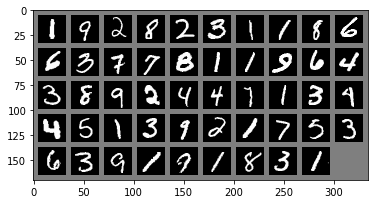

Autoencoder reconstruction:


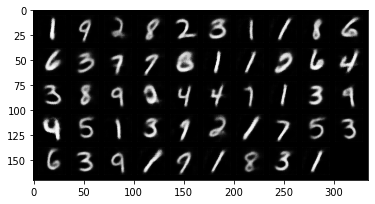

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

encoder.eval()
decoder.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()
# I include it here because it was not included in universal img_transform
images = torchvision.transforms.functional.normalize(images, mean=0.5, std=0.5)

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the autoencoder
print('Autoencoder reconstruction:')
visualise_output(images, lambda x: decoder(encoder(x)))

Random Latent Vector (MNIST Generator)
-------------------------------------------------

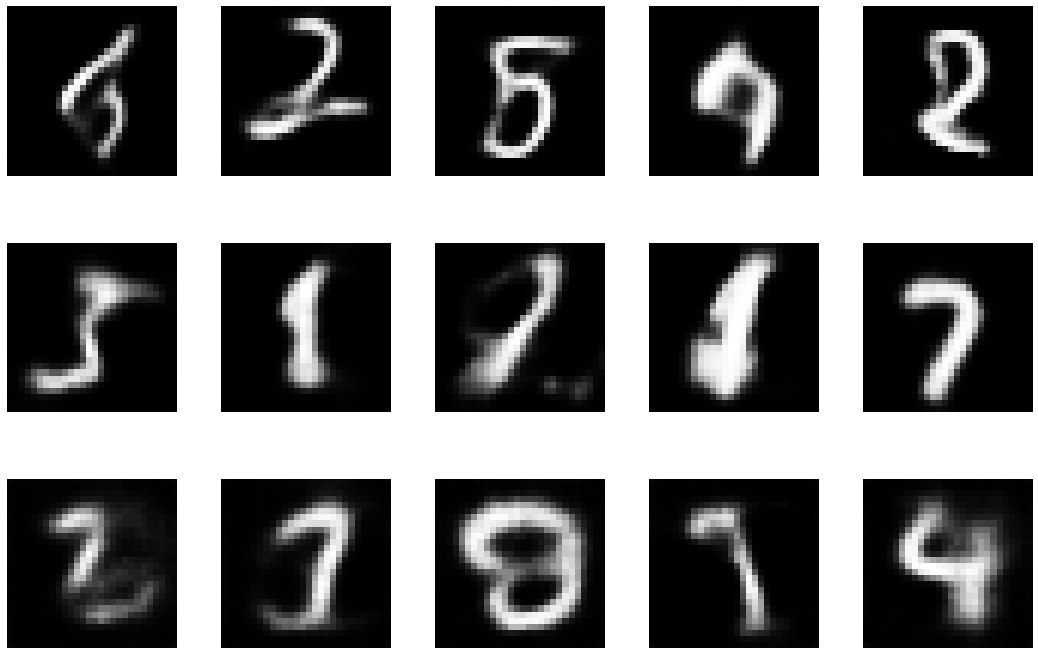

In [ ]:
encoder = Encoder()
encoder.load_state_dict(torch.load("AugInt_encoder50.pth"))
decoder = Decoder()
decoder.load_state_dict(torch.load("AugInt_decoder50.pth"))
encoder = encoder.to(device)
decoder = decoder.to(device)

vanilla_encoder = Vanilla_Encoder()
vanilla_encoder.load_state_dict(torch.load("vanilla_encoder50.pth"))
vanilla_decoder = Vanilla_Decoder()
vanilla_decoder.load_state_dict(torch.load("vanilla_decoder50.pth"))
vanilla_encoder = vanilla_encoder.to(device)
vanilla_decoder = vanilla_decoder.to(device)

noD_encoder = Encoder()
noD_encoder.load_state_dict(torch.load("AugInt_nodiscrim_encoder50.pth"))
noD_decoder = Decoder()
noD_decoder.load_state_dict(torch.load("AugInt_nodiscrim_decoder50.pth"))
noD_encoder = noD_encoder.to(device)
noD_decoder = noD_decoder.to(device)

with torch.no_grad():
    # approx. fit a multivariate Normal distribution (with diagonal cov.) to the latent vectors of a random part of the test set
    images, labels = iter(test_dataloader).next()
    # I include it here because it was not included in universal img_transform
    images = torchvision.transforms.functional.normalize(images, mean=0.5, std=0.5)
    images = images.to(device)
    
    
    #Adversarial AugIntAE#
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, latent_dims) * std + mean

    # reconstruct images from the latent vectors
    latent = latent.to(device)
    adv_augintAE_img_recon = to_img(decoder(latent)[:5])


    #VanillaAE#
    latent = vanilla_encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()

    latent = torch.randn(128, latent_dims) * std + mean

    latent = latent.to(device)
    vanilla_img_recon = to_img(vanilla_decoder(latent)[:5])

    #AugIntAE#
    latent = noD_encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()

    latent = torch.randn(128, latent_dims) * std + mean

    latent = latent.to(device)
    augintAE_img_recon = to_img(noD_decoder(latent)[:5])


    fig, ax  = plt.subplots(3, 5,figsize=(15,15))
    fig.tight_layout(h_pad=-35)

    for i in range(5):
        ax[0,i].imshow(vanilla_img_recon[i].reshape((28,28,)))
        ax[0,i].set_axis_off()
        ax[1,i].imshow(augintAE_img_recon[i].reshape((28,28,)))
        ax[1,i].set_axis_off()
        ax[2,i].imshow(adv_augintAE_img_recon[i].reshape((28,28,)))
        ax[2,i].set_axis_off()

    plt.show()
    fig.savefig("generated_digits.png")

# FID Calculator for the generated digits

In [ ]:
vanilla_encoder = Vanilla_Encoder()
vanilla_encoder.load_state_dict(torch.load("vanilla_encoder50.pth"))
vanilla_decoder = Vanilla_Decoder()
vanilla_decoder.load_state_dict(torch.load("vanilla_decoder50.pth"))
vanilla_encoder = vanilla_encoder.to(device)
vanilla_decoder = vanilla_decoder.to(device)


def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x.cpu().detach().numpy()

test_loss_avg, num_batches = 0, 0
data = []
j=0
for image_batch, _ in test_dataloader:
    print(j)
    if j == 16:
      break

    image_batch = torchvision.transforms.functional.normalize(image_batch, mean=0.5, std=0.5)
    image_batch = image_batch.to(device)
    
    with torch.no_grad():
      #Adversarial AugIntAE#
      latent = vanilla_encoder(image_batch)
      latent = latent.cpu()

      mean = latent.mean(dim=0)
      std = (latent - mean).pow(2).mean(dim=0).sqrt()

      # sample latent vectors from the normal distribution
      latent = torch.randn(128, latent_dims) * std + mean

      # reconstruct images from the latent vectors
      latent = latent.to(device)
      adv_augintAE_img_recon = to_img(vanilla_decoder(latent))
      image_batch = image_batch.cpu().detach().numpy()
      for i in range(adv_augintAE_img_recon.shape[0]):
          #cv2.imwrite("Test/image_%s_%s.jpeg"%(i,j),image_batch[i,:,:,:].reshape((28,28,))*255)
          cv2.imwrite("VanillaAE/image_%s_%s.jpeg"%(i,j),adv_augintAE_img_recon[i,:,:,:].reshape((28,28,))*255)         
      j+=1
      

In [ ]:
!python -m pytorch_fid Test/ VanillaAE/

# EMNIST Few-shot

In [ ]:
#Importing EMNIST data

img_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,)) # I don't include it here cuz affine needs [0, 1]
])

train_dataset = EMNIST(root='./data/EMNIST', download=True, train=True, transform=img_transform, split="letters")
emnist_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = EMNIST(root='./data/EMNIST', download=True, train=False, transform=img_transform,split="letters")
emnist_test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
#Useful functions
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

In [ ]:

vanilla_encoder = Vanilla_Encoder()
vanilla_encoder.load_state_dict(torch.load("vanilla_encoder50_32lat.pth"))
vanilla_decoder = Vanilla_Decoder()
vanilla_decoder.load_state_dict(torch.load("vanilla_decoder50_32lat.pth"))
vanilla_encoder = vanilla_encoder.to(device)
vanilla_decoder = vanilla_decoder.to(device)

noD_encoder = NoD_Encoder()
noD_encoder.load_state_dict(torch.load("AugInt_nodiscrim_encoder50_32lat.pth"))
noD_decoder = NoD_Decoder()
noD_decoder.load_state_dict(torch.load("AugInt_nodiscrim_decoder50_32lat.pth"))
noD_encoder = noD_encoder.to(device)
noD_decoder = noD_decoder.to(device)

encoder = Encoder()
encoder.load_state_dict(torch.load("AugInt_encoder50_32lat.pth"))
decoder = Decoder()
decoder.load_state_dict(torch.load("AugInt_decoder50_32lat.pth"))
encoder = encoder.to(device)
decoder = decoder.to(device)

images, labels = iter(emnist_test_dataloader).next()

images = torchvision.transforms.functional.hflip(images)
images = torchvision.transforms.functional.affine(images, angle=-90, translate=(0,0),scale=1,shear=(0,0))
images = torchvision.transforms.functional.normalize(images, mean=0.5, std=0.5)

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[0:50],10,5))
plt.axis("off")
plt.savefig("original.png")
plt.show()


augmentations_1 = sample_augmentations(augmentation_ranges)
augmentations_2 = sample_augmentations(augmentation_ranges)
images_1 = apply_augmentations(images, augmentations_1)
images_2 = apply_augmentations(images, augmentations_2)
#print('Augmented images 1')
#show_image(torchvision.utils.make_grid(images_1[:50],10,5))
#plt.show()

#print('Augmented images 2')
#show_image(torchvision.utils.make_grid(images_2[0:50],10,5))
#plt.show()

images_1 = images_1.to(device)
images_2 = images_2.to(device)

#Classical VanillaAE
vanilla_latent = vanilla_encoder(images.cuda())
vanilla_output = vanilla_decoder(vanilla_latent).cpu().detach()

alpha=torch.distributions.uniform.Uniform(0.,1.).sample().numpy()

#Combined VanillaAE
latent_1 = vanilla_encoder(images_1)
latent_2 = vanilla_encoder(images_2)
combined_latent = 0.5 * latent_1 + 0.5 * latent_2
combined_vanilla = vanilla_decoder(combined_latent).cpu().detach()

#NoD AugIntAE
latent_1 = noD_encoder(images_1)
latent_2 = noD_encoder(images_2)
combined_latent = 0.5 * latent_1 + 0.5 * latent_2
combined_NoD = noD_decoder(combined_latent).cpu().detach()


#Adversarial AugIntAE
latent_1 = encoder(images_1)
latent_2 = encoder(images_2)

alpha=torch.distributions.uniform.Uniform(0.,1.).sample()

combined_latent = alpha * latent_1 + (1-alpha) * latent_2
combined = decoder(combined_latent).cpu().detach()

print("Few-shot generation")
show_image(torchvision.utils.make_grid(combined[0:50],10,5))
plt.axis("off")
plt.savefig("AdvAugInt_fewshot.png")
plt.show()

fig, ax  = plt.subplots(4, 7,figsize=(15,15))
fig.tight_layout(h_pad=-35)

for i in range(7):
    ax[0,i].imshow(images[i].reshape((28,28,)))
    ax[0,i].set_axis_off()
    ax[1,i].imshow(vanilla_output[i].reshape((28,28,)))
    ax[1,i].set_axis_off()
    ax[2,i].imshow(combined_vanilla[i].reshape((28,28,)))
    ax[2,i].set_axis_off()
    #ax[3,i].imshow(combined[i].reshape((28,28,)))
    #ax[3,i].set_axis_off()

#plt.savefig("vanilla_comparison1.png")
#plt.show()



# FID calculation on EMNIST

In [ ]:
#Generating images for FID calculation
for image_batch, _ in emnist_test_dataloader:
    image_batch = torchvision.transforms.functional.hflip(image_batch)
    image_batch = torchvision.transforms.functional.affine(image_batch, angle=-90, translate=(0,0),scale=1,shear=(0,0))
    image_batch = torchvision.transforms.functional.normalize(image_batch, mean=0.5, std=0.5)

    augmentations_1 = sample_augmentations(augmentation_ranges)
    augmentations_2 = sample_augmentations(augmentation_ranges)
    images_1 = apply_augmentations(images, augmentations_1)
    images_2 = apply_augmentations(images, augmentations_2)

    if j == 16:
        break
    
    with torch.no_grad():

        images = images.to(device)

        latent = vanilla_encoder(images)

        combined_output = vanilla_decoder(latent).cpu().detach().numpy()

        image_batch = image_batch.cpu().detach().numpy()

        for i in range(combined_output.shape[0]):
            #cv2.imwrite("EMNIST/image_%s_%s.jpeg"%(i,j),image_batch[i,:,:,:].reshape((28,28,))*255)
            cv2.imwrite("EMNIST_Vanilla/image_%s_%s.jpeg"%(i,j),combined_output[i,:,:,:].reshape((28,28,))*255)
            
    
    print(j)
    j+=1

In [ ]:
!python -m pytorch_fid EMNIST/ EMNIST_Vanilla/

# Fashion MNIST

Original images


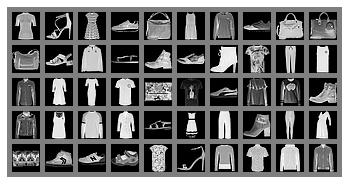

Few-shot generation


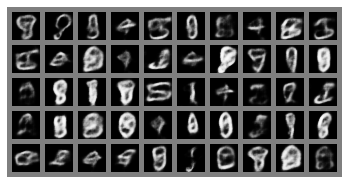

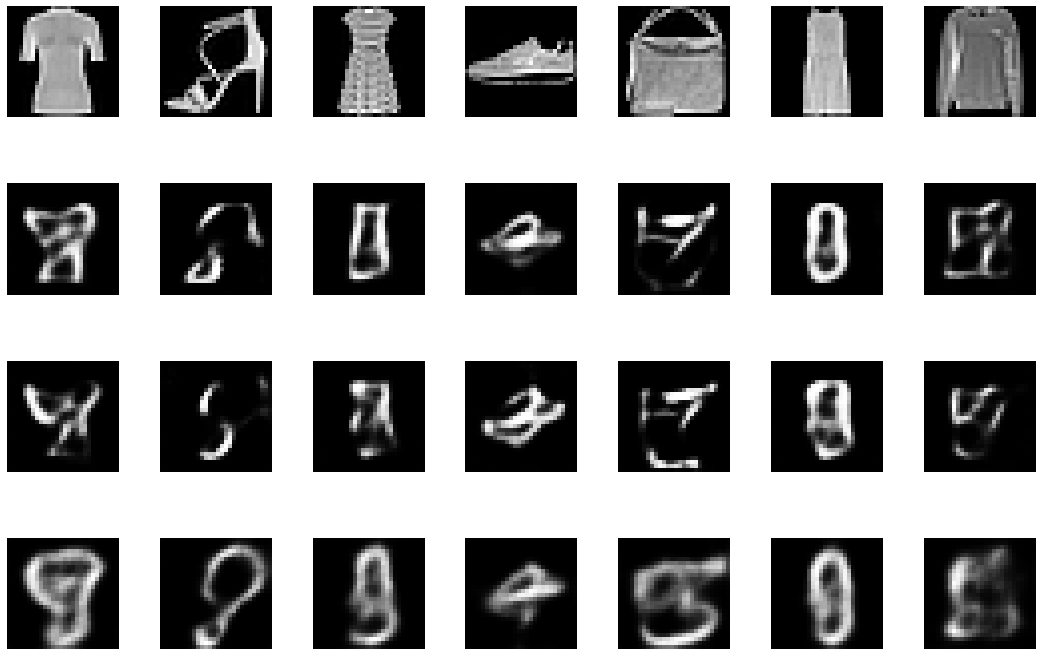

In [ ]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,)) # I don't include it here cuz affine needs [0, 1]
])

train_dataset = FashionMNIST(root='./data/FMNIST', download=True, train=True, transform=img_transform)
fmnist_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = FashionMNIST(root='./data/FMNIST', download=True, train=False, transform=img_transform)
fmnist_test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


vanilla_encoder = Vanilla_Encoder()
vanilla_encoder.load_state_dict(torch.load("vanilla_encoder50_32lat.pth"))
vanilla_decoder = Vanilla_Decoder()
vanilla_decoder.load_state_dict(torch.load("vanilla_decoder50_32lat.pth"))
vanilla_encoder = vanilla_encoder.to(device)
vanilla_decoder = vanilla_decoder.to(device)

noD_encoder = NoD_Encoder()
noD_encoder.load_state_dict(torch.load("AugInt_nodiscrim_encoder50_32lat.pth"))
noD_decoder = NoD_Decoder()
noD_decoder.load_state_dict(torch.load("AugInt_nodiscrim_decoder50_32lat.pth"))
noD_encoder = noD_encoder.to(device)
noD_decoder = noD_decoder.to(device)

encoder = Encoder()
encoder.load_state_dict(torch.load("AugInt_encoder50_32lat.pth"))
decoder = Decoder()
decoder.load_state_dict(torch.load("AugInt_decoder50_32lat.pth"))
encoder = encoder.to(device)
decoder = decoder.to(device)

images, labels = iter(fmnist_test_dataloader).next()

#images = torchvision.transforms.functional.hflip(images)
#images = torchvision.transforms.functional.affine(images, angle=-90, translate=(0,0),scale=1,shear=(0,0))
images = torchvision.transforms.functional.normalize(images, mean=0.5, std=0.5)

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[0:50],10,5))
plt.axis("off")
#plt.savefig("original.png")
plt.show()


augmentations_1 = sample_augmentations(augmentation_ranges)
augmentations_2 = sample_augmentations(augmentation_ranges)
images_1 = apply_augmentations(images, augmentations_1)
images_2 = apply_augmentations(images, augmentations_2)
#print('Augmented images 1')
#show_image(torchvision.utils.make_grid(images_1[:50],10,5))
#plt.show()

#print('Augmented images 2')
#show_image(torchvision.utils.make_grid(images_2[0:50],10,5))
#plt.show()

images_1 = images_1.to(device)
images_2 = images_2.to(device)

#Classical vanilla
vanilla_latent = vanilla_encoder(images.cuda())
vanilla_output = vanilla_decoder(vanilla_latent).cpu().detach()

alpha=torch.distributions.uniform.Uniform(0.,1.).sample().numpy()

#Combined vanilla
latent_1 = vanilla_encoder(images_1)
latent_2 = vanilla_encoder(images_2)
combined_latent = 0.5 * latent_1 + 0.5 * latent_2
combined_vanilla = vanilla_decoder(combined_latent).cpu().detach()

#NoDAugIntAE
latent_1 = noD_encoder(images_1)
latent_2 = noD_encoder(images_2)
combined_latent = 0.5 * latent_1 + 0.5 * latent_2
combined_NoD = noD_decoder(combined_latent).cpu().detach()


#AdvAugIntAE
latent_1 = encoder(images_1)
latent_2 = encoder(images_2)

alpha=torch.distributions.uniform.Uniform(0.,1.).sample()

combined_latent = alpha * latent_1 + (1-alpha) * latent_2
combined = decoder(combined_latent).cpu().detach()

print("Few-shot generation")
show_image(torchvision.utils.make_grid(combined[0:50],10,5))
plt.axis("off")
#plt.savefig("AdvAugInt_fewshot.png")
plt.show()

fig, ax  = plt.subplots(4, 7,figsize=(15,15))
fig.tight_layout(h_pad=-35)

for i in range(7):
    ax[0,i].imshow(images[i].reshape((28,28,)))
    ax[0,i].set_axis_off()
    ax[1,i].imshow(vanilla_output[i].reshape((28,28,)))
    ax[1,i].set_axis_off()
    ax[2,i].imshow(combined_vanilla[i].reshape((28,28,)))
    ax[2,i].set_axis_off()
    ax[3,i].imshow(combined[i].reshape((28,28,)))
    ax[3,i].set_axis_off()

plt.savefig("fmnistcomparison1.png")
plt.show()

